In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [2]:
article_df = pd.read_csv('articles.csv')
article_df.head()

,article_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,...,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc
0,108775015,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,9,Black,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
1,108775044,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,10,White,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
2,108775051,108775,Strap top (1),253,Vest top,Garment Upper body,1010017,Stripe,11,Off White,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
3,110065001,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,9,Black,...,Clean Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."
4,110065002,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,10,White,...,Clean Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."


In [3]:
article_df['article_id'].nunique(), article_df.shape[0]

(105542, 105542)

In [4]:
article_df['prod_name'].nunique()

45875

In [5]:
customer_df = pd.read_csv('customers 2.csv')
customer_df.head()

,customer_id,FN,Active,club_member_status,fashion_news_frequency,age,postal_code
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,NaN,NaN,ACTIVE,NONE,49.0,52043ee2162cf5aa7ee79974281641c6f11a68d276429a...
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,NaN,NaN,ACTIVE,NONE,25.0,2973abc54daa8a5f8ccfe9362140c63247c5eee03f1d93...
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,NaN,NaN,ACTIVE,NONE,24.0,64f17e6a330a85798e4998f62d0930d14db8db1c054af6...
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,NaN,NaN,ACTIVE,NONE,54.0,5d36574f52495e81f019b680c843c443bd343d5ca5b1c2...
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,1.0,1.0,ACTIVE,Regularly,52.0,25fa5ddee9aac01b35208d01736e57942317d756b32ddd...


In [6]:
transactions = pd.read_csv('transactions_train.csv')

In [7]:
print(transactions.shape)

(31788324, 5)


In [8]:
transactions.head()

,t_dat,customer_id,article_id,price,sales_channel_id
0,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,663713001,0.050831,2
1,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,541518023,0.030492,2
2,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,505221004,0.015237,2
3,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687003,0.016932,2
4,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687004,0.016932,2


In [9]:
transactions.dtypes

t_dat                object
customer_id          object
article_id            int64
price               float64
sales_channel_id      int64
dtype: object

In [10]:
transactions['t_dat'] = pd.to_datetime(transactions['t_dat'])
transactions['t_dat'].min(), transactions['t_dat'].max()

(Timestamp('2018-09-20 00:00:00'), Timestamp('2020-09-22 00:00:00'))

In [11]:
hm = transactions.merge(customer_df, on="customer_id", how="left")

In [12]:
hm = hm.merge(article_df, on="article_id", how="left")

In [13]:
hm.head()

,t_dat,customer_id,article_id,price,sales_channel_id,FN,Active,club_member_status,fashion_news_frequency,age,...,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc
0,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,663713001,0.050831,2,NaN,NaN,ACTIVE,NONE,24.0,...,Expressive Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Lace push-up body with underwired, moulded, pa..."
1,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,541518023,0.030492,2,NaN,NaN,ACTIVE,NONE,24.0,...,Casual Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Lace push-up bras with underwired, moulded, pa..."
2,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,505221004,0.015237,2,1.0,1.0,ACTIVE,Regularly,32.0,...,Tops Knitwear DS,D,Divided,2,Divided,58,Divided Selected,1003,Knitwear,Jumper in rib-knit cotton with hard-worn detai...
3,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687003,0.016932,2,1.0,1.0,ACTIVE,Regularly,32.0,...,Campaigns,A,Ladieswear,1,Ladieswear,15,Womens Everyday Collection,1023,Special Offers,V-neck knitted jumper with long sleeves and ri...
4,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687004,0.016932,2,1.0,1.0,ACTIVE,Regularly,32.0,...,Campaigns,A,Ladieswear,1,Ladieswear,15,Womens Everyday Collection,1023,Special Offers,V-neck knitted jumper with long sleeves and ri...


In [14]:
hm.shape

(31788324, 35)

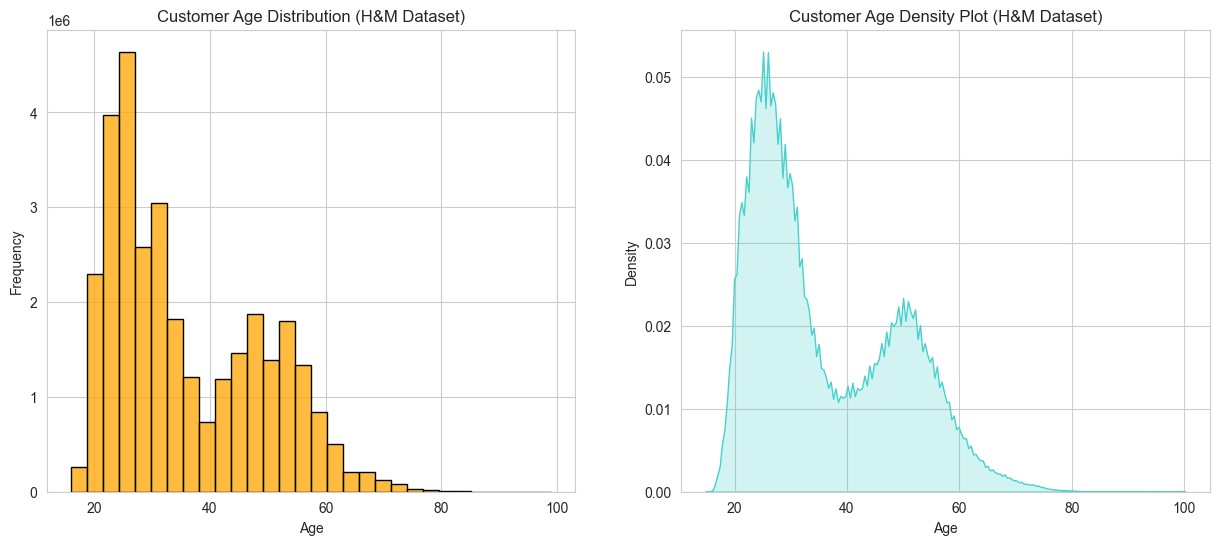

In [17]:
plt.figure(figsize=(15, 6))
sns.set_style("whitegrid")

plt.subplot(1, 2, 1)
sns.histplot(hm['age'], bins=30, color='orange', edgecolor='black')
plt.title('Customer Age Distribution (H&M Dataset)')
plt.xlabel('Age')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
sns.kdeplot(hm['age'], color='mediumturquoise', shade=True)
plt.title('Customer Age Density Plot (H&M Dataset)')
plt.xlabel('Age')
plt.ylabel('Density')
plt.show()

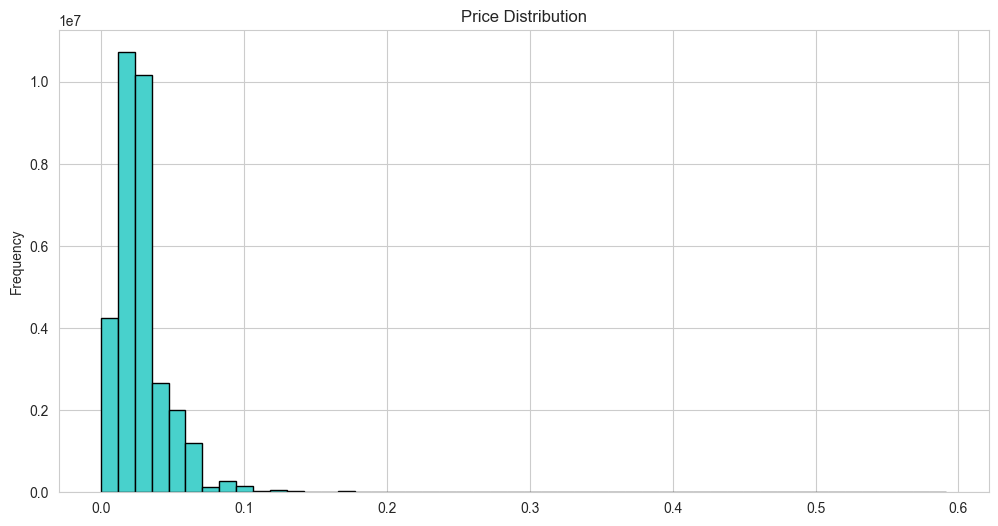

In [18]:
hm['price'].plot(kind='hist', bins=50, figsize=(12,6),color = 'mediumturquoise', edgecolor='black')
plt.title("Price Distribution")
plt.show()

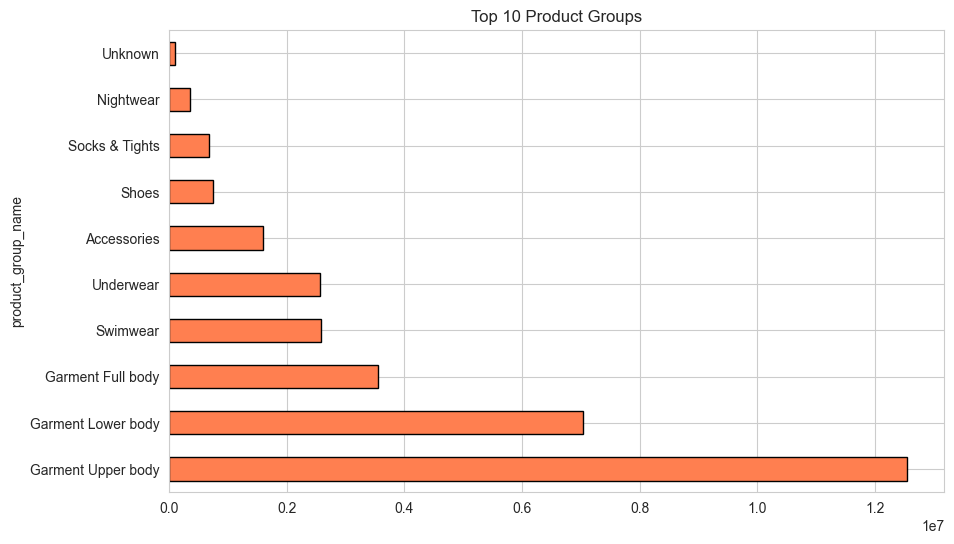

In [19]:
hm['product_group_name'].value_counts().head(10).plot(kind='barh', figsize=(10,6), color='coral', edgecolor='black')
plt.title("Top 10 Product Groups")
plt.show()

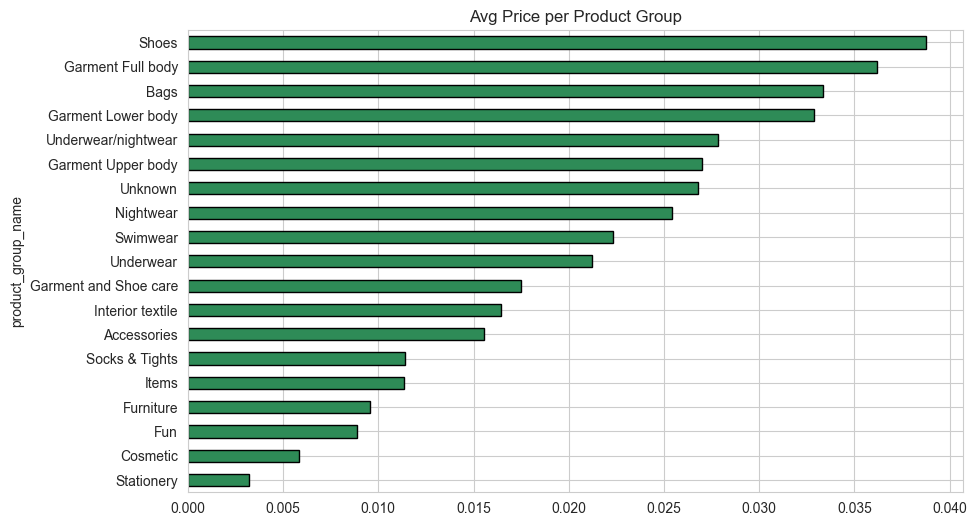

In [20]:
hm.groupby('product_group_name')['price'].mean().sort_values().plot(kind='barh', figsize=(10,6), color='seagreen', edgecolor='black')
plt.title("Avg Price per Product Group")
plt.show()